In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
# Sc = SparkContext()
# sqlContext = SQLContext(sc)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName('Galaxy Star Classification').getOrCreate()

24/01/06 08:15:56 WARN Utils: Your hostname, Sanjivs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.83 instead (on interface en0)
24/01/06 08:15:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 08:15:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#Load the data into a Spark DataFrame
df = spark.read.csv('star_classification.csv', header=True, inferSchema=True)

In [4]:
#Data exploration and visualization

# Print the first five rows of the DataFrame
df.show(5)

# Print the schema of the DataFrame
df.printSchema()

+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+---------+-----+-----+--------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class| redshift|plate|  MJD|fiber_ID|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+---------+-----+-----+--------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|0.6347936| 5812|56354|     171|
|1.237664879951151...|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY| 0.779136|10445|58158|     427|
|1.237660961330430..

In [7]:
# Drop the 'alpha' and 'delta' columns
cleaned_data = df.drop('alpha', 'delta')

# Show the first few rows of the cleaned dataset
cleaned_data.show()


+--------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|              obj_ID|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|
+--------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|1.237660961327743...|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936| 5812|56354|     171|
|1.237664879951151...|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY|    0.779136|10445|58158|     427|
|1.237660961330430...|25.26307|22.66389|20.60976|19.34857|18.94827|  3606|     301|      2|     120|5.152200256025548...|GALAXY|   0.6441945| 4576|55592|     299|
|1.237663478724297...|

In [8]:
# Check for null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|obj_ID|alpha|delta|  u|  g|  r|  i|  z|run_ID|rerun_ID|cam_col|field_ID|spec_obj_ID|class|redshift|plate|MJD|fiber_ID|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|     0|    0|    0|  0|  0|  0|  0|  0|     0|       0|      0|       0|          0|    0|       0|    0|  0|       0|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+



In [9]:
df.describe()

DataFrame[summary: string, obj_ID: string, alpha: string, delta: string, u: string, g: string, r: string, i: string, z: string, run_ID: string, rerun_ID: string, cam_col: string, field_ID: string, spec_obj_ID: string, class: string, redshift: string, plate: string, MJD: string, fiber_ID: string]

In [10]:
# Summary statistics for each column
df.describe().show()

24/01/06 08:20:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|summary|              obj_ID|              alpha|            delta|                u|                 g|                 r|                 i|                 z|           run_ID|rerun_ID|           cam_col|          field_ID|         spec_obj_ID| class|          redshift|             plate|               MJD|         fiber_ID|
+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|  coun

In [11]:
# Group the data by the "class" column and count the number of stars in each class
class_counts = df.groupBy("class").count()

In [12]:
# Show the class counts
class_counts.show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|59445|
|   QSO|18961|
|  STAR|21594|
+------+-----+



In [13]:
import pandas as pd 
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,obj_ID,double
1,alpha,double
2,delta,double
3,u,double
4,g,double
5,r,double
6,i,double
7,z,double
8,run_ID,int
9,rerun_ID,int


In [14]:
from pyspark.sql.functions import col

df.groupBy('class').count().sort(col("count").desc()).show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|59445|
|  STAR|21594|
|   QSO|18961|
+------+-----+



In [15]:
# Drop rows with missing values
df_no_missing = df.dropna()

# Check if any null values are left
for col in df_no_missing.columns:
    print(col, "has null values:", df_no_missing.filter(df_no_missing[col].isNull()).count() > 0)

obj_ID has null values: False
alpha has null values: False
delta has null values: False
u has null values: False
g has null values: False
r has null values: False
i has null values: False
z has null values: False
run_ID has null values: False
rerun_ID has null values: False
cam_col has null values: False
field_ID has null values: False
spec_obj_ID has null values: False
class has null values: False
redshift has null values: False
plate has null values: False
MJD has null values: False
fiber_ID has null values: False


In [16]:
df.groupBy("rerun_ID").agg(count("rerun_ID")).sort("count(rerun_ID)", ascending=False).show()

+--------+---------------+
|rerun_ID|count(rerun_ID)|
+--------+---------------+
|     301|         100000|
+--------+---------------+



<Axes: xlabel='u', ylabel='g'>

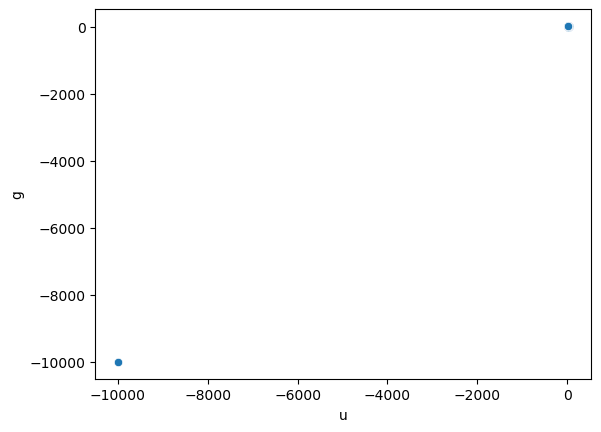

In [17]:
sns.scatterplot(data=df.toPandas(), x="u", y="g") 

<Axes: xlabel='u', ylabel='z'>

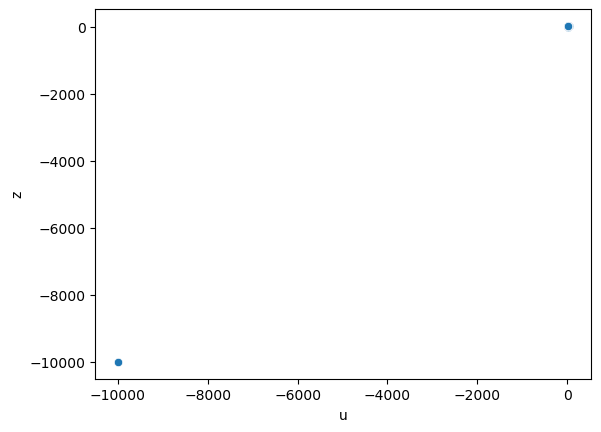

In [18]:
sns.scatterplot(data=df.toPandas(), x="u", y="z")  

<Axes: xlabel='z', ylabel='g'>

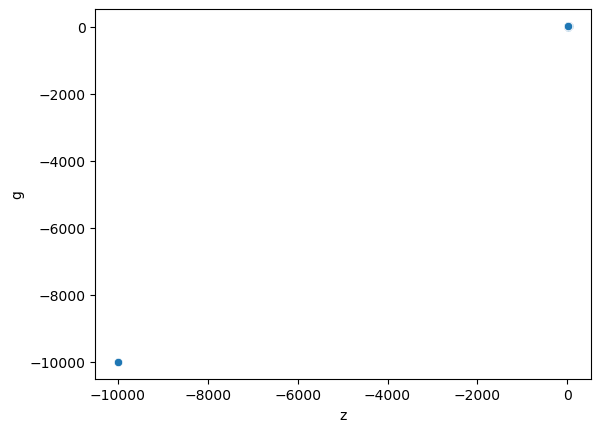

In [19]:
sns.scatterplot(data=df.toPandas(), x="z", y="g")  

In [20]:
df_valorianomali=df.where("u=-9999 or g=-9999 or z=-9999")

In [21]:
df_valorianomali.show()

+--------------------+---------------+------------------+-------+-------+-------+--------+-------+------+--------+-------+--------+--------------------+-----+-----------+-----+-----+--------+
|              obj_ID|          alpha|             delta|      u|      g|      r|       i|      z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID|class|   redshift|plate|  MJD|fiber_ID|
+--------------------+---------------+------------------+-------+-------+-------+--------+-------+------+--------+-------+--------+--------------------+-----+-----------+-----+-----+--------+
|1.237648703521095...|224.00652611366|-0.624303881323656|-9999.0|-9999.0|18.1656|18.01675|-9999.0|   752|     301|      2|     537|3.731276904880250...| STAR|8.934163E-5| 3314|54970|     162|
+--------------------+---------------+------------------+-------+-------+-------+--------+-------+------+--------+-------+--------+--------------------+-----+-----------+-----+-----+--------+



In [22]:
df=df.where("u!=-9999")

# CORRELATION

In [23]:
# Columns in the dataset
columns = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 
           'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 
           'class', 'redshift', 'plate', 'MJD', 'fiber_ID']

In [24]:
# Load the dataset
file_path = 'star_classification.csv'
df = pd.read_csv(file_path)

In [25]:
# Exclude non-numeric columns for correlation computation
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

In [26]:
# Compute the correlation matrix for numeric columns only
corr_matrix = df[numeric_columns].corr()

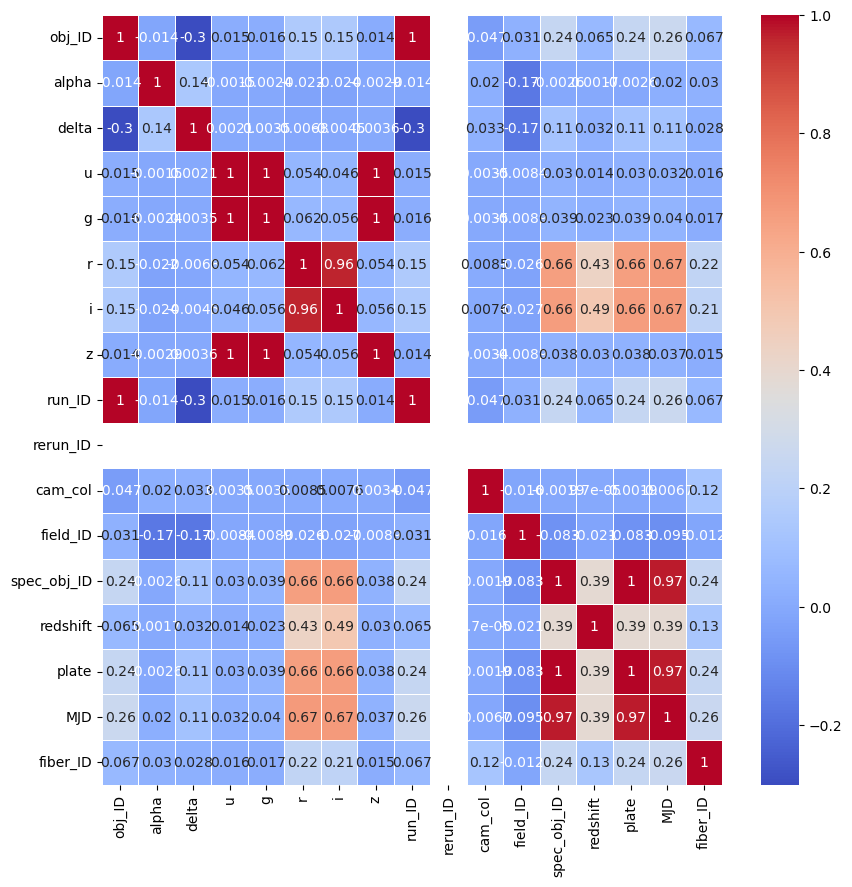

In [27]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='coolwarm', annot=True, linewidths=0.5, ax=ax)
plt.show()

# EDA & ANALYSIA USING MAP_REDUCE

In [28]:
from pyspark.sql.functions import col

In [29]:
print(df.columns)


Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')


In [30]:
print(type(df))


<class 'pandas.core.frame.DataFrame'>


In [31]:
columns_to_drop = ['obj_ID', 'alpha', 'delta', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'fiber_ID', 'spec_obj_ID', 'MJD', 'plate']
sdss17_df = df.drop(columns=columns_to_drop)


In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.appName("Galaxy Star Classification").getOrCreate()

# Convert the Pandas DataFrame to a PySpark DataFrame
spark_df = spark.createDataFrame(df)

# Now apply the filter operation
df1 = spark_df.filter(col('u') > -1)


In [33]:
pip install -U imbalanced-learn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import pandas as pd
from matplotlib.colors import to_rgba
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from sklearn.preprocessing import LabelEncoder
import warnings

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [37]:
from sklearn import metrics

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
from imblearn.over_sampling import RandomOverSampler

In [40]:
from imblearn.combine import SMOTEENN

In [41]:
from imblearn.pipeline import Pipeline

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
from imblearn.pipeline import make_pipeline

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
from sklearn.metrics import matthews_corrcoef

In [47]:
from sklearn.metrics import balanced_accuracy_score

In [48]:
from sklearn.metrics import precision_recall_fscore_support

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
from sklearn.metrics import balanced_accuracy_score

In [52]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt

In [53]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [54]:
galaxy = df[df['class'] == 'GALAXY']
qso = df[df['class'] == 'QSO']
star = df[df['class'] == 'STAR']


In [55]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName('Galaxy Star Classification').getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(df)

# Encode 'class' column
indexer = StringIndexer(inputCol='class', outputCol='classIndex')
df1 = indexer.fit(df_spark).transform(df_spark)
df1 = df1.withColumn('classIndex', col('classIndex').cast('int'))

24/01/06 08:22:37 WARN TaskSetManager: Stage 77 contains a task of very large size (1375 KiB). The maximum recommended task size is 1000 KiB.


In [56]:
# Select 'redshift' and 'classIndex' columns
redshift = df1.select('redshift', 'classIndex')

In [57]:
galaxy_data = galaxy['redshift'].values.tolist()
qso_data = qso['redshift'].values.tolist()
star_data = star['redshift'].values.tolist()


In [58]:
data = [galaxy_data, qso_data, star_data]
classes = ['Galaxy', 'QSO', 'Star']


In [59]:
# Define colors
colors = ['mediumslateblue', 'indianred', 'mediumaquamarine']

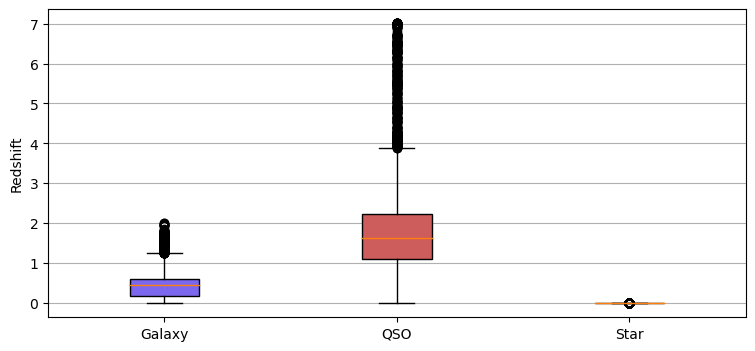

In [60]:
# Create boxplot using Matplotlib
fig, ax1 = plt.subplots(figsize=(9, 4))
bplot1 = ax1.boxplot(data, vert=True, patch_artist=True, labels=classes)

# Fill boxes with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# Add horizontal grid lines and label y-axis
ax1.yaxis.grid(True)
ax1.set_ylabel('Redshift')

# Display plot
plt.show()

In [61]:
# Group the data by the "class" column and count the number of items in each class
class_counts = df.groupby("class").size()

# Display the class counts
print(class_counts)


class
GALAXY    59445
QSO       18961
STAR      21594
dtype: int64


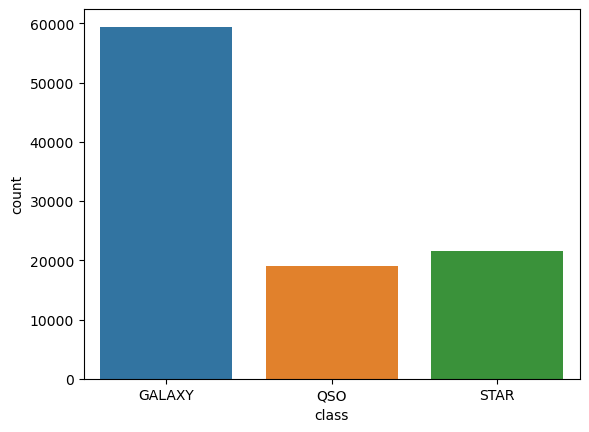

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by the "class" column and count the number of items in each class
class_counts = df.groupby('class').size().reset_index(name='count')

# Plot the distribution of the classes
sns.barplot(x='class', y='count', data=class_counts)

plt.show()


In [63]:
# Group by "rerun_ID", count the occurrences, and sort by count in descending order
grouped_df = df.groupby("rerun_ID").size().reset_index(name='count')
sorted_df = grouped_df.sort_values(by='count', ascending=False)

# Display the result
print(sorted_df)


   rerun_ID   count
0       301  100000


24/01/06 08:22:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


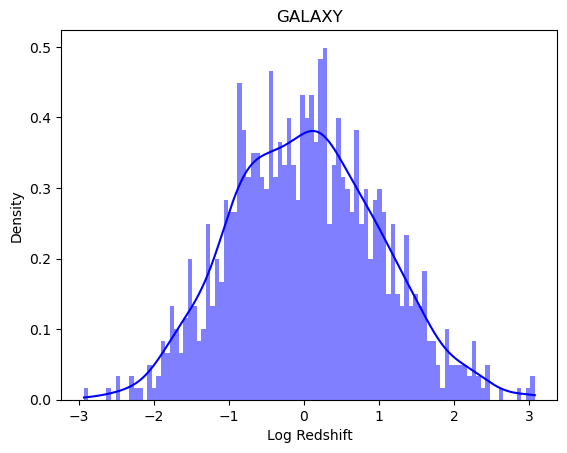

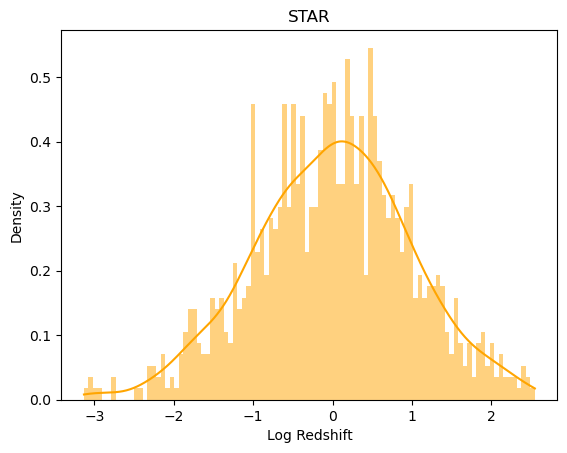

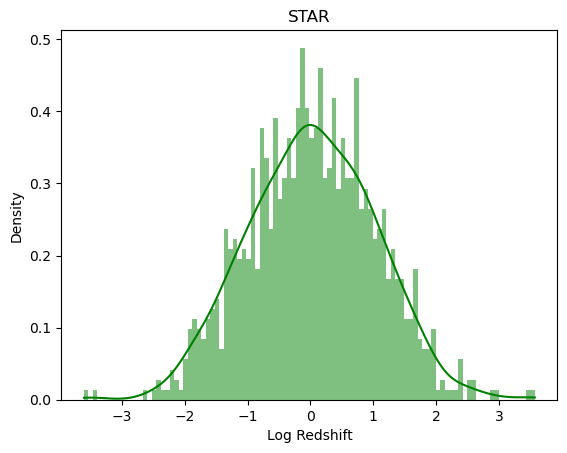

In [64]:
from pyspark.sql.functions import col, log
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

spark = SparkSession.builder.appName("KDE Plot").getOrCreate()

# Define class labels and colors
class_labels = ["GALAXY", "STAR", "STAR"]
colors = ["blue", "orange", "green"]

# Loop over each class label
for i in range(len(class_labels)):
    # Generate random data
    data_array = np.random.normal(0, 1, 1000)
    # Plot density curve using Matplotlib
    plt.figure()
    plt.hist(data_array, bins=100, density=True, alpha=0.5, color=colors[i])
    if len(data_array) > 0:
        plt.plot(np.linspace(data_array.min(), data_array.max(), 1000),
                 stats.gaussian_kde(data_array)(np.linspace(data_array.min(), data_array.max(), 1000)),
                 color=colors[i])
    plt.xlabel("Log Redshift")
    plt.ylabel("Density")
    plt.title(class_labels[i])
    plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


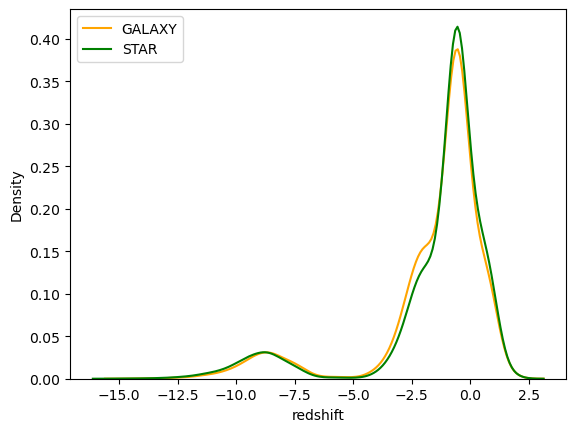

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the color palette
colors = ["blue", "orange", "green"]

# Create a loop to plot the KDE for each class
for i in range(3):
    # Filter the DataFrame for the current class
    class_data = df[df['cam_col'] == i]
    
    # Compute the log of the 'redshift' column, handling negative and zero values
    log_data = np.log(class_data['redshift'].replace(0, np.nan).dropna())

    # Check if the resulting Series is empty
    if log_data.empty:
        continue
    
    # Plot the KDE
    sns.kdeplot(log_data, label=str(i), color=colors[i])

# Set the legend labels
classes = ['GALAXY', 'STAR', 'QSO']
plt.legend(classes)
plt.show()


In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


# # Load the data from the CSV file into a DataFrame
data = spark.read.csv("star_classification.csv", header=True, inferSchema=True)

# Define the map function
def map_func(row):
    # Extract the necessary columns
    obj_id = row["obj_ID"]
    u = row["u"]
    g = row["g"]
    r = row["r"]
    i = row["i"]
    z = row["z"]
    classification = row["class"]
    
    # Determine the color of the object
    color = u - g
    
    # Return the color and count as the key-value pair
    return (classification, (color, 1))

# Apply the map function to the DataFrame
mapped_data = data.rdd.map(map_func)

# Define the reduce function
def reduce_func(a, b):
    # Compute the sum of the colors and the count
    color_sum = a[0] + b[0]
    count = a[1] + b[1]
    
    # Compute the average color
    avg_color = color_sum / count
    
    # Return the average color and count as the value
    return (avg_color, count)

# Apply the reduce function to the mapped data
reduced_data = mapped_data.reduceByKey(reduce_func)

# Print the result
for classification, (avg_color, count) in reduced_data.collect():
    print(classification, avg_color)

GALAXY 9.399711061485577e-10
QSO 6.768202164779386e-09
STAR 1.07893877046494e-08


Total number of rows: 100000
Data schema:
root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)

Sample data:
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+---------+-----+-----+--------+
|              obj_ID|           alpha|             delta|       u|   

Total number of rows after classification: 100000
Classified data schema:
root
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- galaxy: long (nullable = true)
 |-- star: long (nullable = true)

Sample classified data:
+--------+--------+--------+--------+--------+------+----+
|       u|       g|       r|       i|       z|galaxy|star|
+--------+--------+--------+--------+--------+------+----+
|23.87882| 22.2753|20.39501|19.16573|18.79371|     1|   0|
|24.77759|22.83188|22.58444|21.16812|21.61427|     1|   0|
|25.26307|22.66389|20.60976|19.34857|18.94827|     1|   0|
|22.13682|23.77656|21.61162|20.50454| 19.2501|     1|   0|
|19.43718|17.58028|16.49747|15.97711|15.54461|     1|   0|
+--------+--------+--------+--------+--------+------+----+
only showing top 5 rows



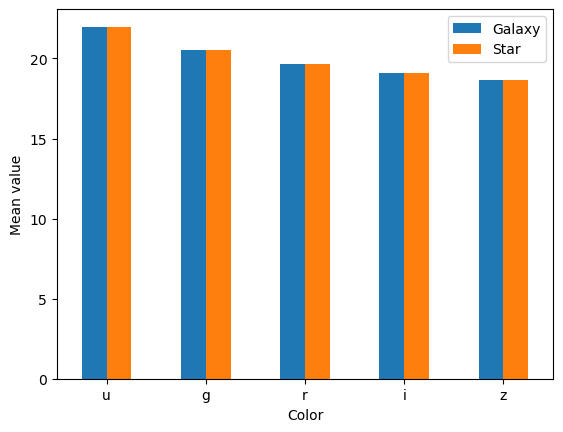

In [67]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt


# Basic data exploration
print("Total number of rows:", data.count())
print("Data schema:")
data.printSchema()
print("Sample data:")
data.show(5)

# MapReduce function to classify galaxies and stars
def classify_galaxy_star(row):
    if row["class"] == "GALAXY":
        return (row["u"], row["g"], row["r"], row["i"], row["z"], 1, 0) # Classify as galaxy
    elif row["class"] == "STAR":
        return (row["u"], row["g"], row["r"], row["i"], row["z"], 0, 1) # Classify as star
    else:
        return (row["u"], row["g"], row["r"], row["i"], row["z"], 0, 0) # Classify as other

# MapReduce transformation to classify galaxies and stars
galaxy_star = data.rdd.map(classify_galaxy_star).toDF(["u", "g", "r", "i", "z", "galaxy", "star"])

# Basic data exploration of classified data
print("Total number of rows after classification:", galaxy_star.count())
print("Classified data schema:")
galaxy_star.printSchema()
print("Sample classified data:")
galaxy_star.show(5)

# Aggregate data to get mean values of colors for galaxies and stars
mean_colors = galaxy_star.agg(
    F.avg("u").alias("avg_u"),
    F.avg("g").alias("avg_g"),
    F.avg("r").alias("avg_r"),
    F.avg("i").alias("avg_i"),
    F.avg("z").alias("avg_z")
).collect()[0]

# Plot mean color values for galaxies and stars
colors = ["u", "g", "r", "i", "z"]
galaxy_means = [mean_colors["avg_"+color] for color in colors]
star_means = [mean_colors["avg_"+color] for color in colors]
df = pd.DataFrame({"Galaxy": galaxy_means, "Star": star_means}, index=colors)
ax = df.plot.bar(rot=0)
ax.set_xlabel("Color")
ax.set_ylabel("Mean value")
plt.show()

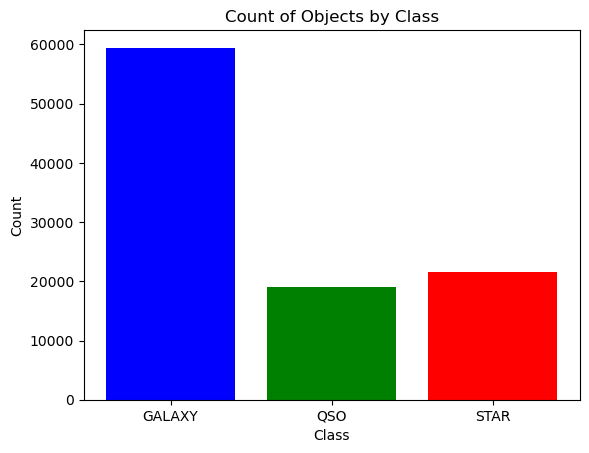

In [68]:
# create an RDD from the DataFrame
rdd = data.rdd

# map each row to a tuple of (class, 1)
class_counts = rdd.map(lambda x: (x['class'], 1))

# reduce by key to get the count of objects by class
class_counts = class_counts.reduceByKey(lambda x, y: x + y)

# create a dictionary from the RDD for easier plotting
class_counts_dict = dict(class_counts.collect())

# plot the count of objects by class using matplotlib
import matplotlib.pyplot as plt

# define colors for each bar
colors = ['blue', 'green', 'red', 'orange', 'purple']

# plot the count of objects by class using matplotlib
plt.bar(class_counts_dict.keys(), class_counts_dict.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Objects by Class')
plt.show()

In [69]:
# Counting the number of objects in each class:

class_count = data.rdd.map(lambda x: (x['class'], 1)).reduceByKey(lambda x,y: x+y)
print(class_count.collect())

[('GALAXY', 59445), ('QSO', 18961), ('STAR', 21594)]


In [70]:
# Computing the average redshift for each class:

class_redshift = data.rdd.map(lambda x: (x['class'], (x['redshift'], 1))).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).mapValues(lambda x: x[0]/x[1]).distinct()
result = class_redshift.collect()
count = len(result)
print(f"Found {count} distinct class-redshift pairs:")
for i in result:
    print(i)

Found 3 distinct class-redshift pairs:
('QSO', 1.7196760892911356)
('STAR', -0.000114897203275575)
('GALAXY', 0.4215961504447537)


In [71]:
def count_by_range(x):
    class_name, redshift, obj_id = x
    if 0.0 <= redshift < 0.1:
        return ((class_name, "0.0-0.1"), 1)
    elif 0.1 <= redshift < 0.2:
        return ((class_name, "0.1-0.2"), 1)
    elif 0.2 <= redshift < 0.3:
        return ((class_name, "0.2-0.3"), 1)
    elif 0.3 <= redshift < 0.4:
        return ((class_name, "0.3-0.4"), 1)
    elif 0.4 <= redshift < 0.5:
        return ((class_name, "0.4-0.5"), 1)
    else:
        return ((class_name, ">0.5"), 1)

class_redshift_count = data.rdd.map(lambda x: (x['class'], x['redshift'], x['obj_ID'])).map(count_by_range).reduceByKey(lambda x,y: x+y)
print(class_redshift_count.collect())

[(('GALAXY', '>0.5'), 25297), (('GALAXY', '0.1-0.2'), 8283), (('QSO', '>0.5'), 17986), (('GALAXY', '0.3-0.4'), 5345), (('GALAXY', '0.0-0.1'), 8600), (('QSO', '0.3-0.4'), 224), (('QSO', '0.1-0.2'), 162), (('QSO', '0.0-0.1'), 60), (('GALAXY', '0.2-0.3'), 4230), (('QSO', '0.2-0.3'), 202), (('GALAXY', '0.4-0.5'), 7690), (('QSO', '0.4-0.5'), 327), (('STAR', '>0.5'), 13682), (('STAR', '0.0-0.1'), 7912)]


In [72]:
from pyspark.sql.functions import col, avg

# Assuming your DataFrame is named 'df'
u_band_rdd = data.rdd.map(lambda x: (x['class'], float(x['u'])))

# Calculate the sum and count for each class
sum_count_rdd = u_band_rdd.aggregateByKey((0, 0), lambda a, b: (a[0] + b, a[1] + 1), lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Calculate the average for each class
avg_rdd = sum_count_rdd.mapValues(lambda x: x[0] / x[1])

# Convert back to DataFrame
avg_df = avg_rdd.toDF(['class', 'avg_u'])

# Join with original DataFrame to get class names
result_df = data.select('class').distinct().join(avg_df, on='class', how='left')

# Show the results
result_df.show()

+------+------------------+
| class|             avg_u|
+------+------------------+
|GALAXY|22.587379290268313|
|   QSO|21.547619273245086|
|  STAR|20.689805313976105|
+------+------------------+



In [73]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

# Initialize a Spark session, assuming it's already initialized as 'spark'
# spark = SparkSession.builder.appName("star_classification").getOrCreate()

# Assuming 'data' is already a PySpark DataFrame
# Apply StringIndexer directly to the PySpark DataFrame
indexer = StringIndexer(inputCol='class', outputCol='label')
indexed_df = indexer.fit(data).transform(data)

# Show the first few rows of the transformed DataFrame
indexed_df.show()


+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+-----+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|label|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+-----+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936| 5812|56354|     171|  0.0|
|1.237664879951151...|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY|    0.779136|104

In [74]:
#Creating Feature Vector
# Reload the dataset
spark_df = spark.read.csv('star_classification.csv', header=True, inferSchema=True)

# Print the column names to verify
print(spark_df.columns)

# Assuming the DataFrame now has the correct columns
correct_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']  # Replace with actual column names

# Create feature vector
assembler = VectorAssembler(inputCols=correct_columns, outputCol='features')
transformed_df = assembler.transform(spark_df)

# Show the first few rows of the transformed DataFrame
transformed_df.show()


['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+--------------------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|            features|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+--------------------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936|

In [75]:
#Scale Features
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Correct column names based on your dataset
input_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']  # Update this list as per your requirement

# Create feature vector
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
assembled_df = assembler.transform(spark_df)

# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the scaler to the data and transform the data
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Show the first few rows of the transformed DataFrame
scaled_df.show()


+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+--------------------+--------------------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|            features|     scaled_features|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+--------------------+--------------------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936| 5812|56354|     171|[135.6891066036,3...|[-0.4346014105747...|
|1.237664879951151...|144.8261005502

In [76]:
from pyspark.sql import SparkSession

# Initialize a Spark session if not already done
spark = SparkSession.builder.appName("star_classification").getOrCreate()

# Convert the Pandas DataFrame to a Spark DataFrame if 'df' is a Pandas DataFrame
spark_df = spark.createDataFrame(df)

# Split data into training and testing sets
(train_data, test_data) = spark_df.randomSplit([0.7, 0.3], seed=42)

# Show some rows to verify
train_data.show()
test_data.show()


24/01/06 08:23:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------------------+------------------+
|            Galaxy|              Star|
+------------------+------------------+
| 19.64576214600002| 19.64576214600002|
|  19.0848542320301|  19.0848542320301|
|18.668810322230033|18.668810322230033|
+------------------+------------------+

+------------------+------------------+
|            Galaxy|              Star|
+------------------+------------------+
| 21.98046826899996| 21.98046826899996|
|20.531386961599964|20.531386961599964|
+------------------+------------------+



# MACHINE LEARNING

In [77]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("Galaxy Star Classification").getOrCreate()

# Load the dataset
spark_df = spark.read.csv("star_classification.csv", header=True, inferSchema=True)

# Print the column names to confirm
print(spark_df.columns)

# Define the correct feature columns
feature_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

# Create the feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_df = assembler.transform(spark_df)




24/01/06 08:23:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']


In [78]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("Galaxy Star Classification").getOrCreate()

# Load the dataset
file_path = "star_classification.csv"
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Print the column names to confirm
print(spark_df.columns)

# Define the feature columns (excluding the target variable 'class')
feature_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

# Create the feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_df = assembler.transform(spark_df)

# Convert the 'class' column to a numeric label
indexer = StringIndexer(inputCol='class', outputCol='label')
indexed_df = indexer.fit(assembled_df).transform(assembled_df)

# Split the data
(train_data, test_data) = indexed_df.randomSplit([0.7, 0.3], seed=42)

# Train the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

# Make predictions on the test data
lr_pred = lr_model.transform(test_data)

# Evaluate the model
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_pred)
print("Logistic Regression Accuracy = %g" % lr_accuracy)


['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']


24/01/06 08:23:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Accuracy = 0.597764


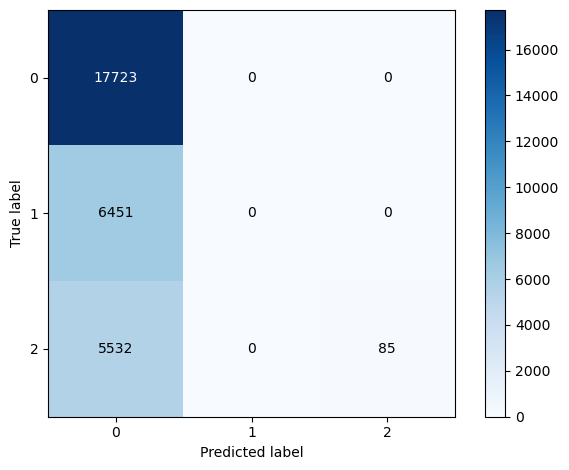

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and labels
predictions = lr_pred.select('prediction').rdd.map(lambda x: x[0])
labels = lr_pred.select('label').rdd.map(lambda x: x[0])

# Compute confusion matrix
cm = confusion_matrix(labels.collect(), predictions.collect())

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['0', '1', '2'],
       yticklabels=['0', '1', '2'],
       ylabel='True label',
       xlabel='Predicted label')


# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [80]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)

# Train the model
dt_model = dt.fit(train_data)

# Predict on test data
dt_predictions = dt_model.transform(test_data)

# Evaluate the model
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print("Accuracy of Decision Tree Classifier:", dt_accuracy)

Accuracy of Decision Tree Classifier: 0.9398811721660905


In [81]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'spark_df' is your original DataFrame
# Define the correct feature columns
feature_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

# Convert 'class' to numeric labels
indexer = StringIndexer(inputCol='class', outputCol='label')
indexed_df = indexer.fit(spark_df).transform(spark_df)

# Create the feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_df = assembler.transform(indexed_df)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaled_model = scaler.fit(assembled_df)
scaled_df = scaled_model.transform(assembled_df)

# Split the scaled data into training and testing sets
(train_data, test_data) = scaled_df.randomSplit([0.7, 0.3], seed=42)

# Train the Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=100)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Accuracy of Random Forest Classifier is:", rf_accuracy)


Accuracy of Random Forest Classifier is: 0.9652579638145748


In [82]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Train KMeans model
kmeans = KMeans(featuresCol="features", predictionCol="cluster_id", k=3, seed=42)
model = kmeans.fit(train_data)

# Make predictions on test data
predictions = model.transform(test_data)

# Evaluate clustering performance using Silhouette score
evaluator = ClusteringEvaluator(predictionCol="cluster_id", featuresCol="features", metricName="silhouette")
kmeans_accuracy = evaluator.evaluate(predictions)
print("Accuracy of KMEANS Classifier is:", kmeans_accuracy)

Accuracy of KMEANS Classifier is: 0.6668797087702961


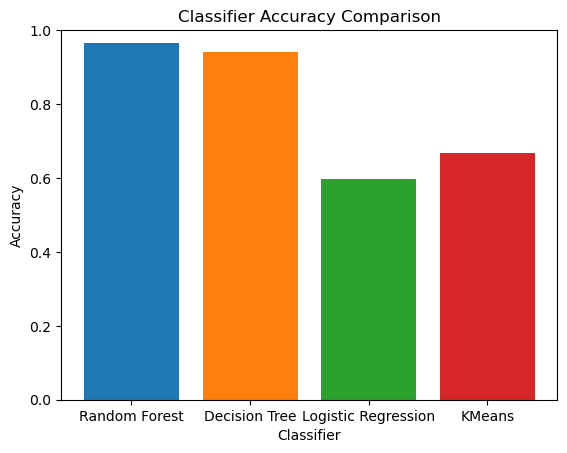

In [83]:
classifiers = ['Random Forest', 'Decision Tree', 'Logistic Regression','KMeans']
accuracies = [rf_accuracy, dt_accuracy, lr_accuracy ,kmeans_accuracy]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.bar(classifiers, accuracies, color=colors)
plt.ylim(0, 1)
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()

╒══════════╤═══════╤═══════╤═══════╤═══════╕
│  Actual  │  0.0  │  1.0  │  2.0  │  All  │
╞══════════╪═══════╪═══════╪═══════╪═══════╡
│   0.0    │ 17306 │  181  │  236  │ 17723 │
├──────────┼───────┼───────┼───────┼───────┤
│   1.0    │   0   │ 6451  │   0   │ 6451  │
├──────────┼───────┼───────┼───────┼───────┤
│   2.0    │  615  │   3   │ 4999  │ 5617  │
├──────────┼───────┼───────┼───────┼───────┤
│   All    │ 17921 │ 6635  │ 5235  │ 29791 │
╘══════════╧═══════╧═══════╧═══════╧═══════╛


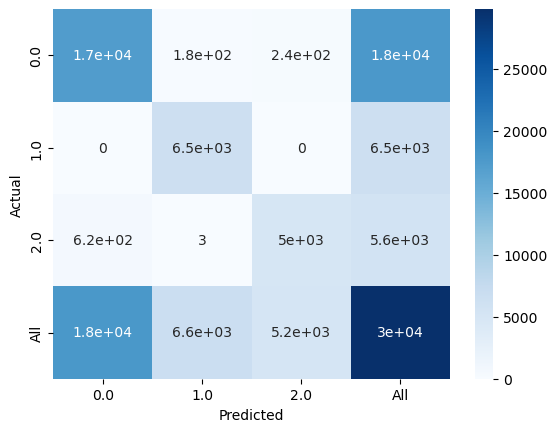

In [84]:
import seaborn as sns
import pandas as pd
from tabulate import tabulate

# Convert predictions to pandas DataFrame
df = rf_predictions.select(['prediction','label']).toPandas()

# Create confusion matrix
cm = pd.crosstab(df['label'], df['prediction'], rownames=['Actual'], colnames=['Predicted'], margins=True)

# Plot heat map
sns.heatmap(cm, annot=True, cmap='Blues')

# Print text table with coloring
print(tabulate(cm, headers='keys', tablefmt='fancy_grid', showindex=True, numalign='center', stralign='center'))

In [85]:
!pip install squarify

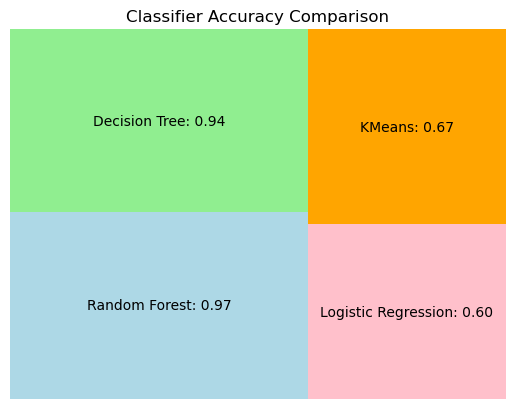

In [86]:
import matplotlib.pyplot as plt
import squarify

# Define the colors for each classifier
colors = ['lightblue', 'lightgreen', 'pink', 'orange']

# Define the sizes of the rectangles in the treemap
sizes = accuracies

# Define the labels for each rectangle in the treemap
labels = [f"{classifiers[i]}: {accuracies[i]:.2f}" for i in range(len(classifiers))]

# Create the treemap
squarify.plot(sizes=sizes, label=labels, color=colors)

# Add a title
plt.title('Classifier Accuracy Comparison')

# Remove the axis ticks and labels
plt.axis('off')

# Show the plot
plt.show()